In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from seaborn import heatmap
from sklearn.decomposition import PCA


pd.set_option('display.max_columns', 40)
plt.rcParams['figure.figsize'] = 12,7
plt.rcParams['figure.dpi'] = 100


df: pd.DataFrame = pd.read_csv("Life Expectancy Data.csv")
df_copy = df.copy()


# Formatting DataFrame for further analysis
stripped_columns = []

for col_num, col_name in enumerate(df.columns):
    stripped_columns.append(col_name.strip(' '))
    
df.columns = stripped_columns

df = df.sort_values(by=['Country', 'Year'])
df = df.reset_index(drop=True)

df_wo_null_values = df.copy()
df_wo_null_values = df_wo_null_values.dropna()
df_wo_null_values = df_wo_null_values.reset_index(drop=True)


**<h4>**Handling outliers**<h4>**

In [99]:
for column in df_wo_null_values.columns[4:]:

    descriptive_stats = df_wo_null_values[column].describe()


    median = descriptive_stats['50%']
    Q1 = descriptive_stats['25%']
    Q3 = descriptive_stats['75%']
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    IQR_range = (lower_bound, upper_bound)

    upper_outliers_boolean_indexing = df_wo_null_values[column] > upper_bound
    lower_outliers_boolean_indexing = df_wo_null_values[column] < lower_bound

    combined_boolean_indexing = (upper_outliers_boolean_indexing | lower_outliers_boolean_indexing)

    df_wo_null_values[column] = df_wo_null_values[column].mask(
        cond = combined_boolean_indexing,
        other = median
        )
    



In [111]:
df_wo_null_values['Adult Mortality'].describe()

q1 = 77.0
median = 144.0
q3 = 227.0
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr




condition = df_wo_null_values['Adult Mortality'] > upper_bound
second_condition = df_wo_null_values['Adult Mortality'] < lower_bound
combined_boolean_indexing = (condition | second_condition)

df_wo_null_values['Adult Mortality'].mask(
        cond = combined_boolean_indexing,
        other = median
        )

0       321.0
1       316.0
2         3.0
3       295.0
4       293.0
        ...  
1644    148.0
1645    148.0
1646    429.0
1647    399.0
1648    371.0
Name: Adult Mortality, Length: 1649, dtype: float64

**<h1>**As the data represents a bunch of time serieses across different countries it is reasonable to assume that we might better split this task into 2:**</h1>**

**<h3>**1. Regression anaylysis for each year<br>2. Multivariate time series analysis for each country**</h3>**


**<h5>**It is also reasonable to do the regression analysis for each year as the bare minimum condition of having atleast 5-6 training example per feature is satisfied**</h5>**


In [2]:
regression_df = df.copy()
regression_df = regression_df.sort_values(by='Year')
regression_df = regression_df.reset_index(drop=True)

regression_df['Status'] = regression_df['Status'].replace({
    "Developed": 1,
    "Developing": 0,
})


**<h2>**Handling missing data**</h2>**
**<h4>**For every column that contains NULL values we look for the indexes of missing values in order to understand the nature of the absence**<h4>**

In [4]:
columns_with_null_values = regression_df.columns[(regression_df.isnull().sum()>0).values]
column_and_indeces = {}

for column in columns_with_null_values:
    column_and_indeces[column] = regression_df[regression_df[column].isnull()==True].index

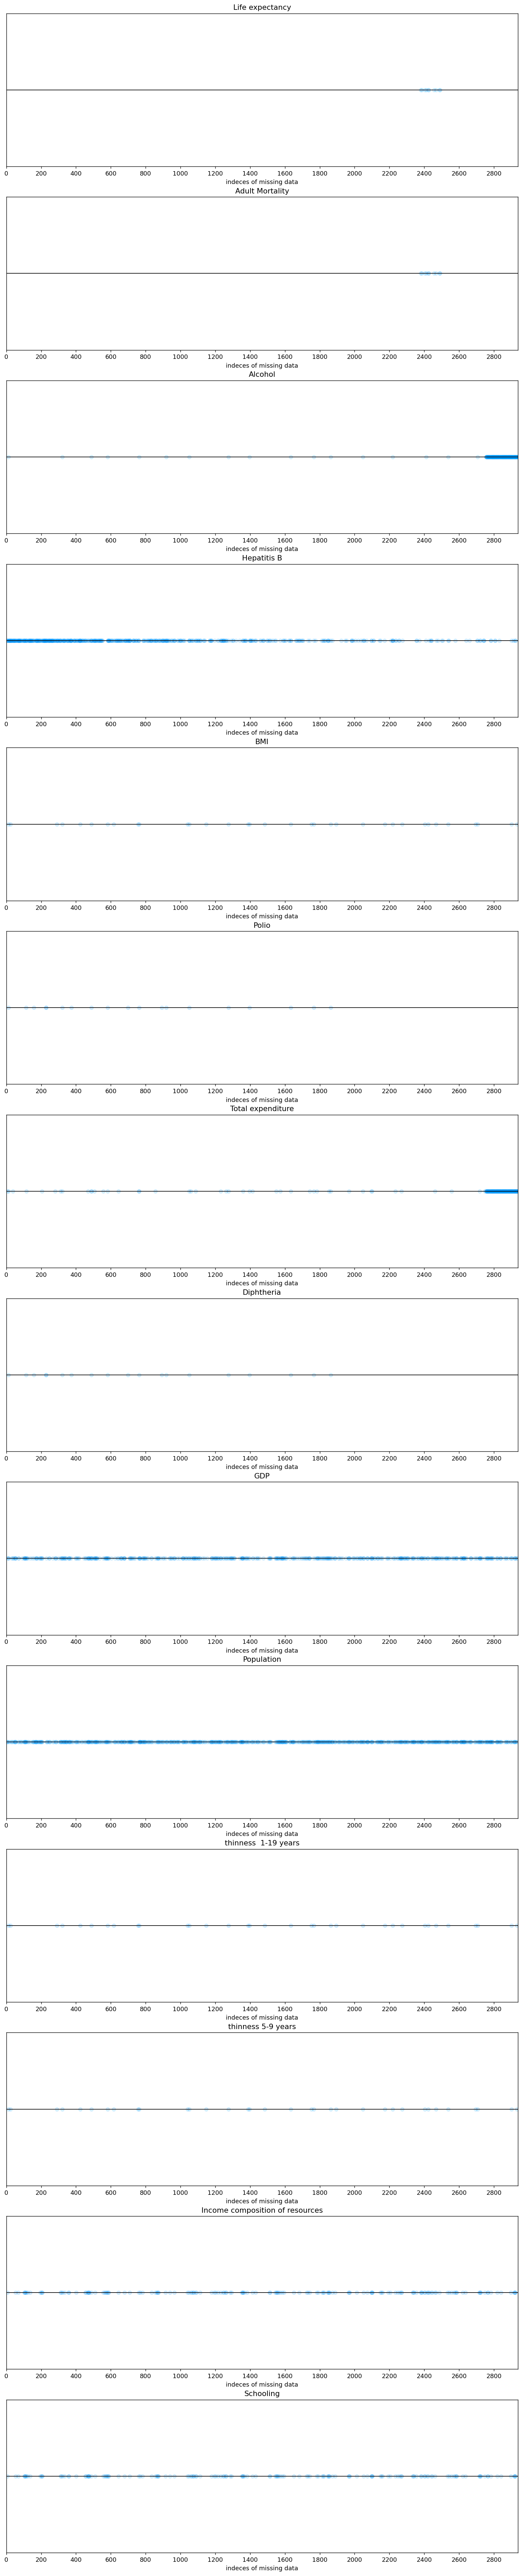

In [8]:
fig, axes = plt.subplots(len(column_and_indeces), figsize = (15, 75), dpi = 130)
xmin = 0
xmax = 2938


for index, (key, values) in enumerate(column_and_indeces.items()):
    axes[index].hlines(y=0, xmin=xmin, xmax=xmax, color='black', linewidth=1)

    axes[index].scatter(values, [0] * len(values), color=(0,0.6,1), alpha=0.15)

    axes[index].set_yticks([])
    axes[index].set_xticks(np.arange(xmin, xmax, 200))

    axes[index].set_xlim(0, 2938)
    axes[index].set_ylim(-1, 1)

    axes[index].set_title(key)
    axes[index].set_xlabel("indeces of missing data")


In [8]:
metrics_with_weird_behavior = [
    'Alcohol',
    'BMI',
    'Polio',
    'Total expenditure',
    'Diphtheria',
    'thinness  1-19 years',
    'thinness 5-9 years',
]

countries_total_missing_values = {}


for metric in metrics_with_weird_behavior:
    df = pd.DataFrame(regression_df[regression_df[metric].isnull()==True]['Country'].value_counts())

    for item in df.iterrows():
        if item[0] in countries_total_missing_values.keys():
            countries_total_missing_values[item[0]]+=item[1].values[0]
        else:
            countries_total_missing_values[item[0]] = item[1].values[0]


pd.DataFrame(
                {
                    'Country': countries_total_missing_values.keys(),
                    'Total_Null': countries_total_missing_values.values()
                }             
             ).sort_values(by='Total_Null', ascending=False)[:15]

,Country,Total_Null
0,South Sudan,99
62,Sudan,50
67,Somalia,17
50,Democratic People's Republic of Korea,17
1,Montenegro,15
42,Timor-Leste,6
171,Iraq,5
178,Monaco,3
179,San Marino,3
124,Argentina,2


**<h3>**We can see, that South Sudan and Sudan miss lots of data, so it'd be reasonable to drop the data instances from South Sudan & Sudan**</h3>**

In [9]:
regression_df = regression_df[regression_df['Country']!='South Sudan']
regression_df = regression_df[regression_df['Country']!='Sudan']

regression_df.reset_index(drop=True, inplace=True)


**<h3>**As the other indices of missing data are distributed rather randomly we can omit the step with analyzing them as it is pretty safe to say that the reason for the absence of some metrics is random**</h3>**

In [10]:
regression_df_wo_null = regression_df.copy()
regression_df_wo_null = regression_df_wo_null.dropna()

<Axes: >

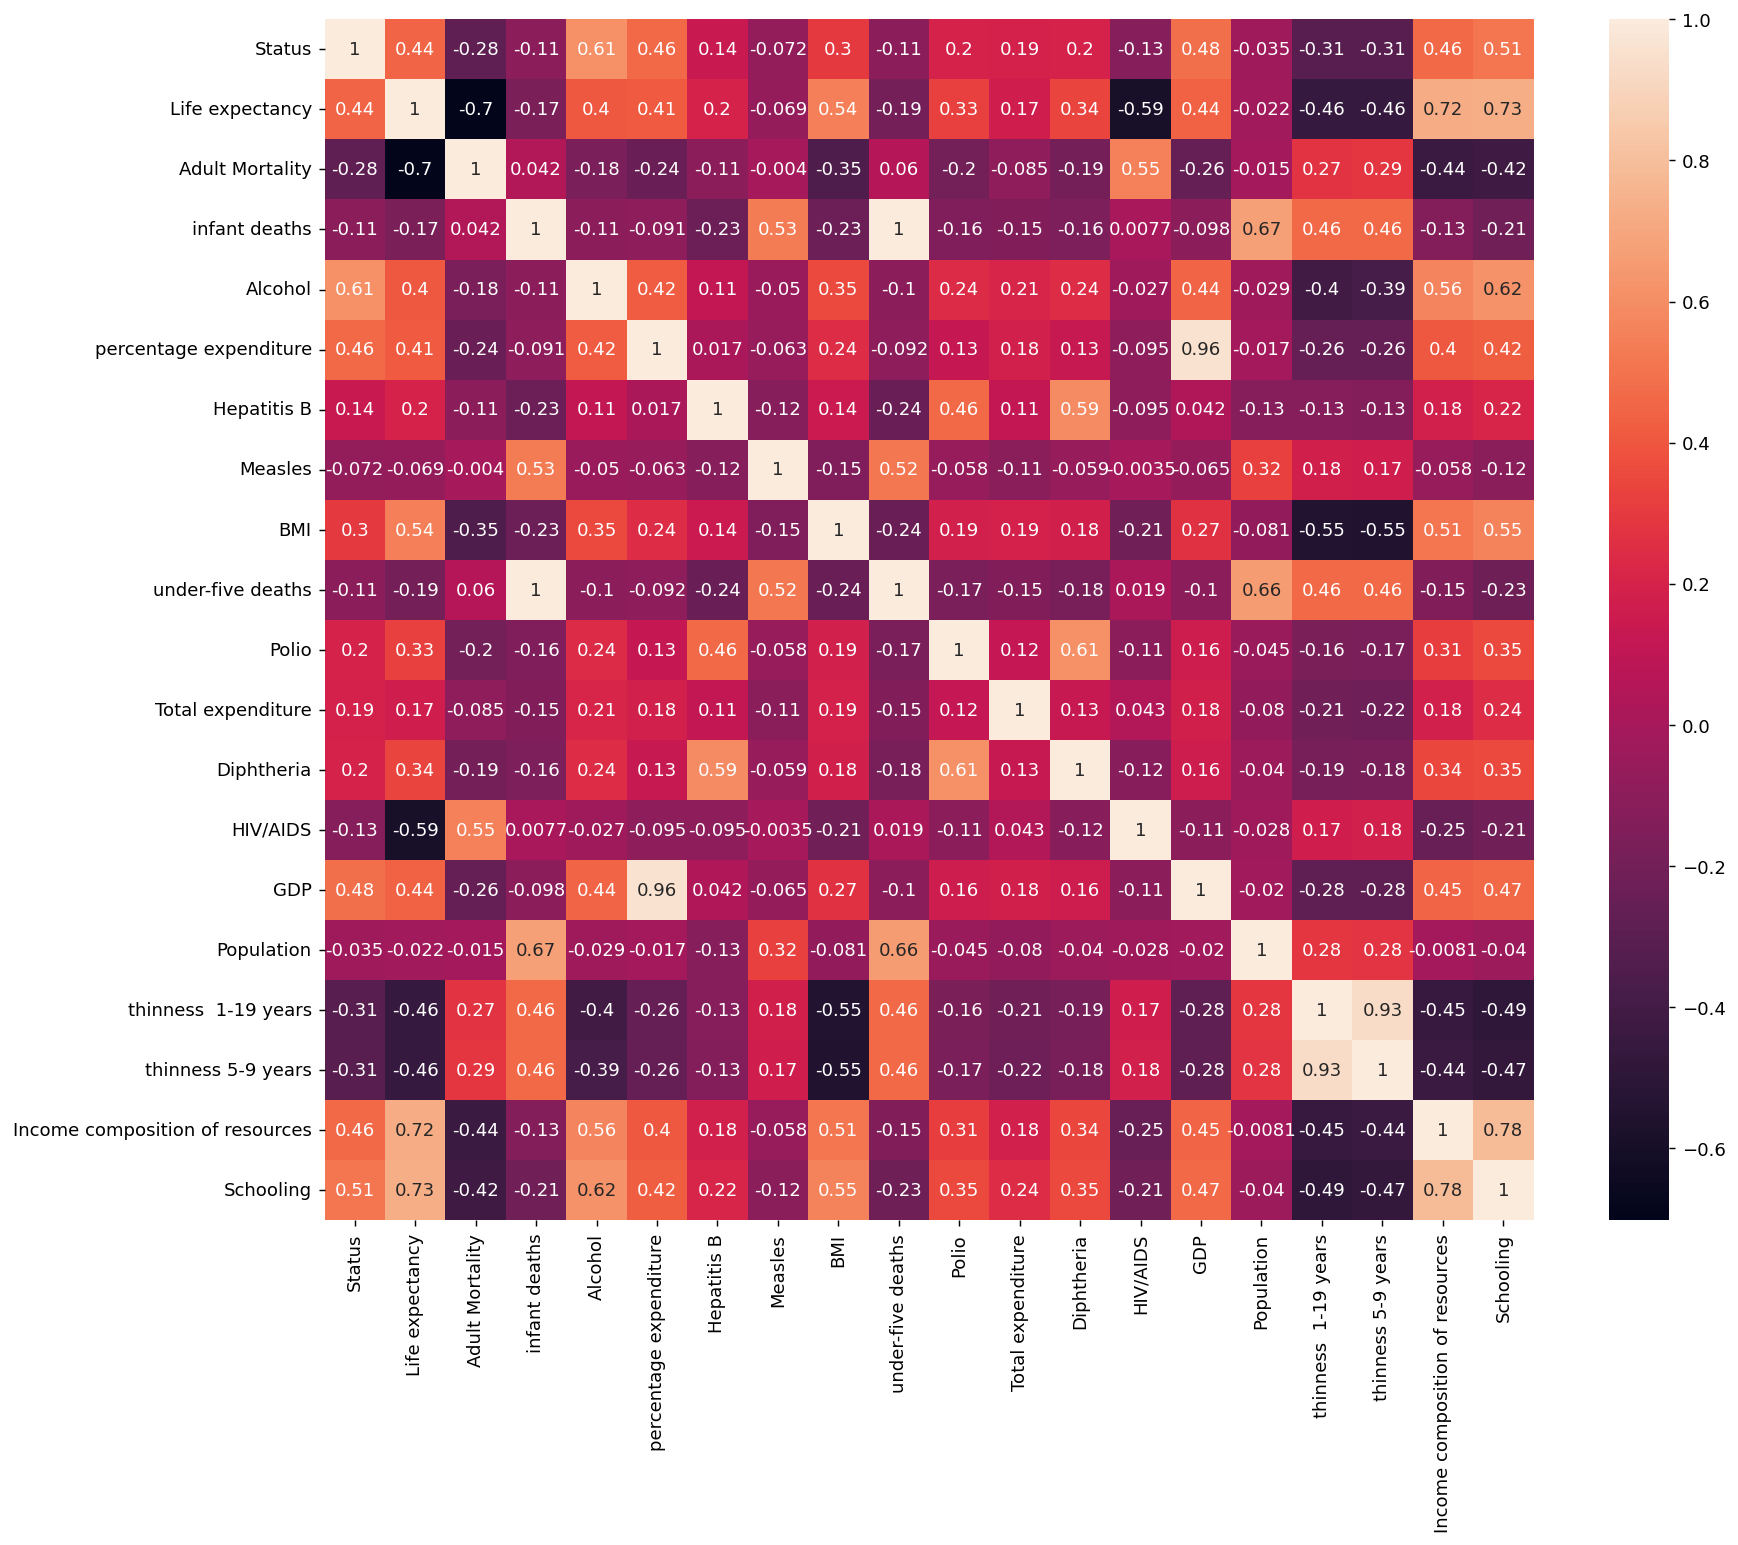

In [11]:
fig, ax = plt.subplots(figsize = (15,12), dpi=130)


heatmap(regression_df_wo_null[regression_df_wo_null.columns[2:]].corr(), annot=True, ax=ax)

**<h3>**Principal Component Analysis**</h3>**

In [ ]:
for column in regression_df_wo_null.columns[2:]:
    x = regression_df_wo_null[column]
    regression_df_wo_null[column] = (x-x.mean())/x.std(ddof=1)

regression_df_wo_null_features = regression_df_wo_null[regression_df_wo_null.columns[2:]]



pca = PCA(n_components = len(regression_df_wo_null_features.columns))
pca.fit(regression_df_wo_null_features)
sliced_regression_df_wo_null = pca.transform(regression_df_wo_null_features)



importance = np.abs(pca.components_) * pca.explained_variance_ratio_.reshape(-1, 1)
feature_importance = importance.sum(axis=0)

for col_name, importance in zip(regression_df.columns[2:], feature_importance):
    print(col_name, '-', importance)

Status - 0.19699322427835786
Life expectancy - 0.18855691788539425
Adult Mortality - 0.19624449716165662
infant deaths - 0.16494114754591244
Alcohol - 0.20486707088350192
percentage expenditure - 0.19701900284680665
Hepatitis B - 0.16712813971883445
Measles - 0.17713064270794332
BMI - 0.17782070970918795
under-five deaths - 0.16487076071707057
Polio - 0.1695702510682359
Total expenditure - 0.1374042618662436
Diphtheria - 0.16127733936491748
HIV/AIDS - 0.1826919059674301
GDP - 0.1996752925756833
Population - 0.1676294298385733
thinness  1-19 years - 0.20452615901037027
thinness 5-9 years - 0.20333164341659438
Income composition of resources - 0.18255649559758771
Schooling - 0.17570815848002164


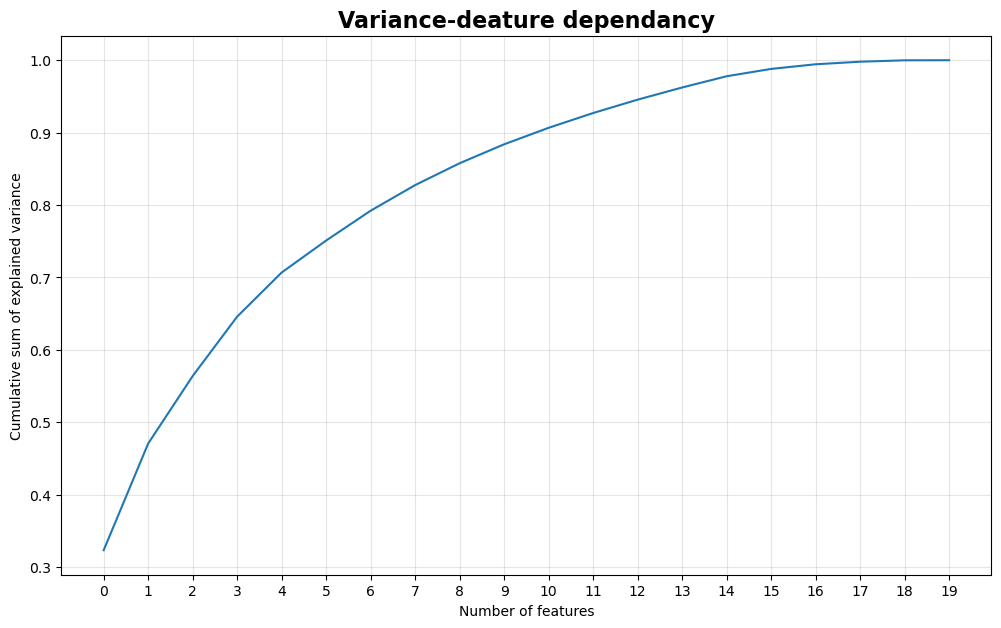

In [ ]:
cumsum_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(cumsum_variance)
plt.grid(alpha=.33)
plt.xticks(np.arange(len(regression_df_wo_null_features.columns)))
plt.ylabel('Cumulative sum of explained variance')
plt.xlabel('Number of features')
plt.title('Variance-deature dependency', fontdict={'fontsize': 16, 'weight': 'bold'})
plt.show()

**<h3>**With the help of correlation matrix and PCA we can say that there are a couple of features that highly correlated with other features, which is not good from statistical point of view, so we're going to remove certain features from the dataset**</h3>**

**<h3>**We also saw that all the features contribte to the target variable relatively the same**</h3>**

**<h4>**I'll leave this problem of filling NA values for future as I've got some ideas, but do not have enough time**</h4>**



In [15]:
regression_df = regression_df.dropna().reset_index(drop=True)
regression_df = regression_df.drop(['Country', 'under-five deaths', 'percentage expenditure', 'thinness 5-9 years'], axis=1)
num_of_observations_per_year = regression_df.groupby('Year')['Life expectancy'].count()
num_of_observations_per_year

Year
2000     61
2001     66
2002     81
2003     95
2004    103
2005    110
2006    114
2007    120
2008    123
2009    126
2010    128
2011    130
2012    129
2013    130
2014    131
2015      2
Name: Life expectancy, dtype: int64

**<h3>**From the series above we can see that aftrer filtering out null data we have only certain years we can use for regression models because some of the years do not contain enough data**<h3>**

In [ ]:
relevant_years = num_of_observations_per_year[num_of_observations_per_year>100].index
regression_df = regression_df[regression_df['Year'].isin(relevant_years)]

regression_dfs_by_year = {year: df for year, df in regression_df.groupby('Year')}

**<h3>**Importing 3 differenet models for regression task:**</h3>**
<h5>1. Random Forest<br>2. Linear Regression<br>3. Support Vector Regression</h5>

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR


linreg = LinearRegression()
svr_rbf = SVR(kernel="rbf", C=10, gamma=0.1, epsilon=0.1)
randforest = RandomForestRegressor(n_estimators=100, max_depth=5, bootstrap=True)


**<h3>**Solving time series task**<h3>**

In [ ]:
tsa_df = df.copy()
tsa_df = tsa_df.sort_values(by=['Country', 'Year'])
tsa_df = tsa_df.dropna().reset_index(drop=True)
tsa_df = tsa_df.drop(['under-five deaths', 'percentage expenditure', 'thinness 5-9 years'], axis=1)
num_of_observations_per_country = tsa_df.groupby('Country')['Life expectancy'].count()
relevant_countries = num_of_observations_per_country[num_of_observations_per_country.sort_values(ascending=True)>10]

Country
Afghanistan    16
Albania        16
Algeria        11
Argentina      13
Armenia        15
               ..
Ukraine        15
Uruguay        15
Uzbekistan     13
Vanuatu        15
Zimbabwe       15
Name: Life expectancy, Length: 101, dtype: int64

In [18]:
tsa_dfs_by_country = {year: df for year, df in df.groupby('Country')}

**<h5>**We can see that some of the columns contain null values, thus let us analyze it throughly, so we can think about how we'll handle them**<h5>**

**<h3>**Attempt to handle missing values via cosine similarity**<h3>**

In [ ]:
from numpy import dot
from numpy.linalg import norm   

def cos_similarity(a: tuple | list, b: tuple | list) -> np.float64:
    
    return dot(a, b)/(norm(a)*norm(b))

df["feature_vector"] = df[numerical_columns].apply(lambda row: tuple(row.fillna(0)), axis=1)


instances_with_null_values = []

for row_num, row in df.isnull().iterrows():
    if True in row.values:
        instances_with_null_values.append(row_num)

instances_with_null_values[:5]

row_for_row = {}

for row_num in instances_with_null_values:
    similarities = []
    for another_row in df.index[df.index!=row_num]:

        similarity = cos_similarity(df["feature_vector"][row_num], df["feature_vector"][another_row])
        similarities.append(similarity)
        # if similarity>list(max_similarity.values())[0]:
        #     max_similarity[another_row]=similarity
    row_for_row[row_num] = similarities

    

    

[32, 44, 45, 46, 47]

In [ ]:
df[df['infant deaths']==df['infant deaths'].max()]

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
1200,India,2001,Developing,62.9,222.0,1800,1.00,19.003406,NaN,51780,11.8,2400,58.0,4.50,59.0,0.3,447.138966,171477855.0,27.5,28.5,0.494,8.3
1201,India,2000,Developing,62.5,224.0,1800,0.93,19.266157,NaN,38835,11.4,2500,57.0,4.26,58.0,0.3,438.864634,1535912.0,27.7,28.6,0.489,8.3


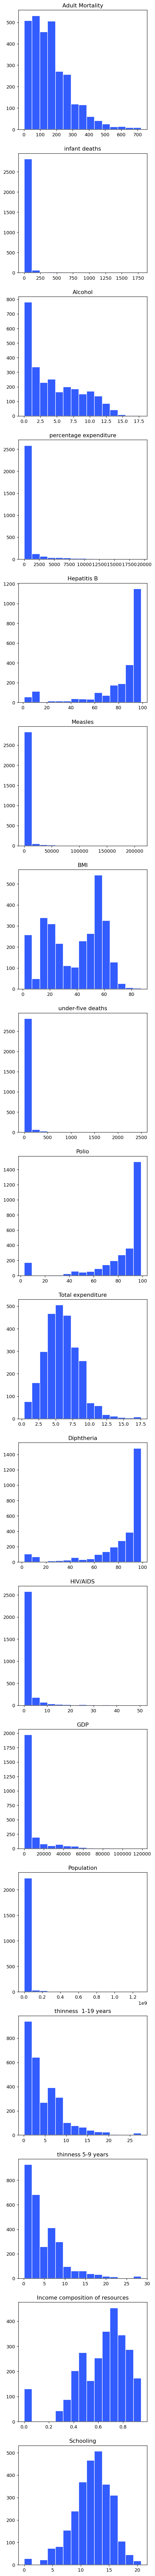

In [ ]:
fig, axes = plt.subplots(len(numerical_columns), figsize = (5, 100), dpi = 130)


for col_num, col_name in enumerate(numerical_columns):
    axes[col_num].hist(df[col_name], bins = 15, color = (0, 0.2, 1, 0.8), edgecolor='white')
    axes[col_num].set_title(f"{col_name}")

**USA BMI has false information, to be specific, in 2000 and 2001**

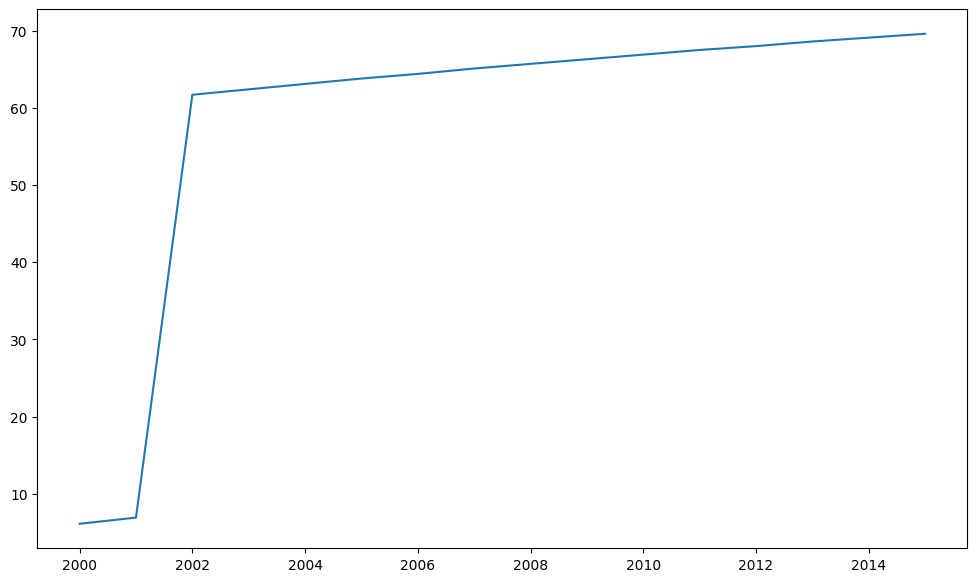

In [ ]:
year = df[df['Country']=='United States of America'].sort_values(by='Year', ascending=True)['Year']

bmi = df[df['Country']=='United States of America'].sort_values(by='Year', ascending=True)['BMI']


plt.plot(year, bmi)

In [ ]:
df.sort_values(by='BMI')

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
2887,Viet Nam,2002,Developing,73.8,137.0,30,2.03,0.000000,NaN,6755,1.0,39,92.0,4.70,75.0,0.2,NaN,NaN,15.6,16.3,0.584,10.7
2886,Viet Nam,2003,Developing,74.0,137.0,30,2.19,0.000000,78.0,2297,1.4,37,96.0,4.84,99.0,0.2,NaN,NaN,15.6,16.2,0.592,10.9
207,Bangladesh,2000,Developing,65.3,173.0,231,0.01,3.696331,NaN,5098,1.4,316,83.0,2.33,82.0,0.1,45.633710,131581243.0,2.9,21.5,0.459,7.3
206,Bangladesh,2001,Developing,65.8,168.0,219,0.01,3.395070,NaN,4414,1.8,298,85.0,2.47,85.0,0.1,42.598115,1341716.0,2.7,21.3,0.468,7.5
2885,Viet Nam,2004,Developing,74.2,136.0,29,2.86,0.000000,94.0,217,1.9,36,96.0,5.90,96.0,0.2,NaN,NaN,15.4,16.1,0.601,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2468,Sudan,2004,Developing,59.7,278.0,68,1.59,37.044800,NaN,9562,NaN,102,74.0,3.39,74.0,0.2,565.569459,3186341.0,NaN,NaN,0.415,5.7
2469,Sudan,2003,Developing,59.6,278.0,69,1.74,35.352647,NaN,4381,NaN,104,69.0,3.18,69.0,0.2,477.738478,29435944.0,NaN,NaN,0.409,5.6
2470,Sudan,2002,Developing,59.4,277.0,70,1.59,30.622875,NaN,4529,NaN,106,6.0,2.95,6.0,0.2,412.151756,28679565.0,NaN,NaN,0.403,5.6
2471,Sudan,2001,Developing,58.9,283.0,71,1.81,28.880697,NaN,4362,NaN,108,66.0,2.96,66.0,0.2,377.525445,279455.0,NaN,NaN,0.399,5.6


In [ ]:
df.iloc[2471]['BMI']

nan

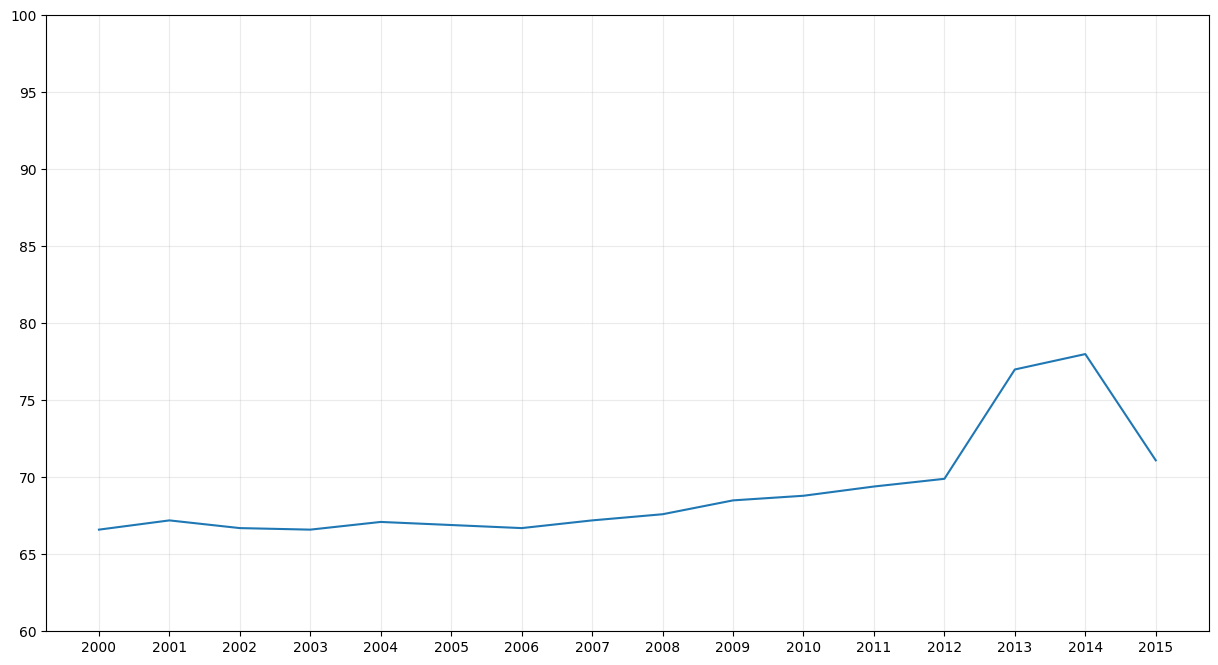

In [ ]:
fig, ax = plt.subplots(figsize = (15,8), dpi = 100)


ax.plot(
    df[df['Country']=='Kyrgyzstan']['Year'],
    df[df['Country']=='Kyrgyzstan']['Life expectancy']
    )
ax.grid(alpha=0.25)
ax.set_ylim([60, 100])
ax.set_xticks(np.arange(2000, 2016, 1))
plt.show()

<Axes: >

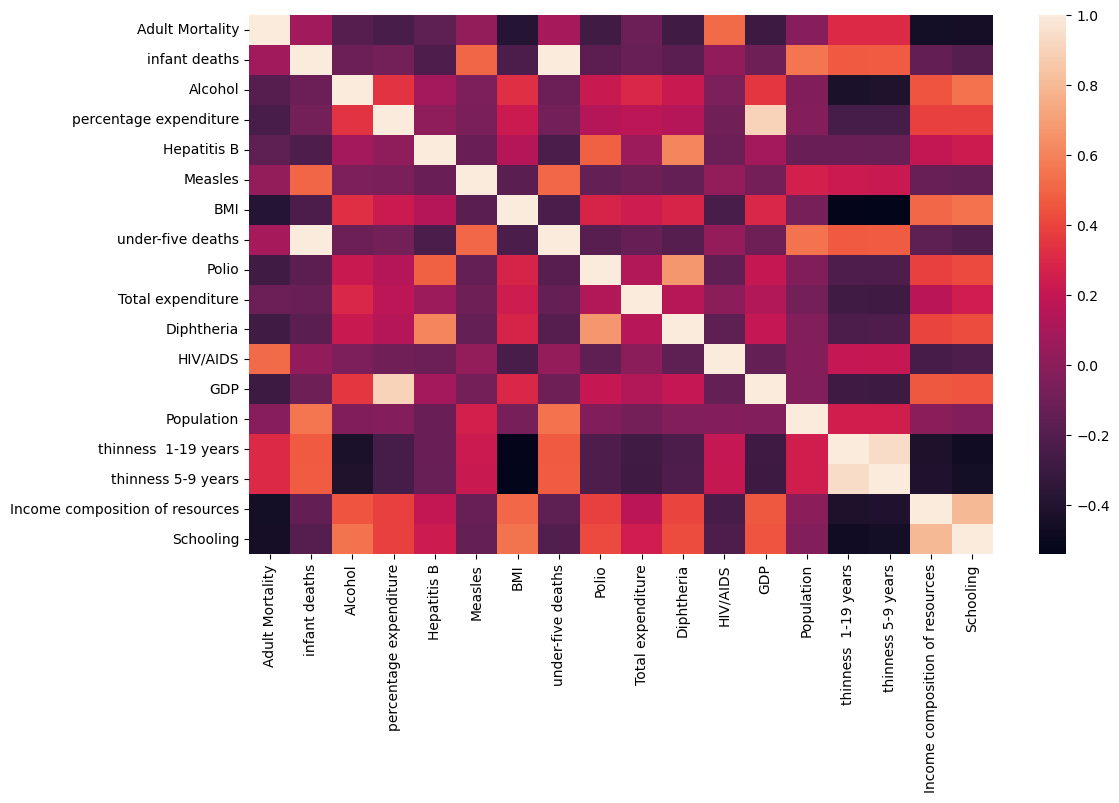

In [ ]:
heatmap(df[numerical_columns].corr())